In [1]:
%reset -f
%matplotlib inline
from ast import literal_eval
from copy import deepcopy as copy
from itertools import product as cprod
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth

from aux import sgmd, get_segments
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.00, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 3},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# ANALYSIS
A_PARAMS = {
    'smoothness': 4,  # 2 ms
    
}

## Functional replay with inhibition

Triggered replay is slower. Spontaneous replay beginning in middle of LTP-IE-tagged path spreads in only one direction due to competition. Inhibition is recruited in oscillatory rather than constant pattern, suggestive of SWRs (although frequency is not correct).

Running smln...
Smln complete.


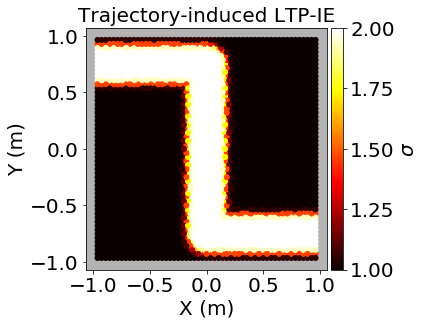

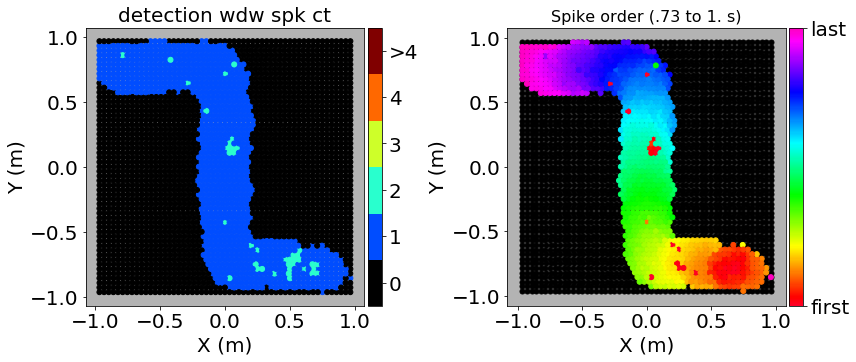

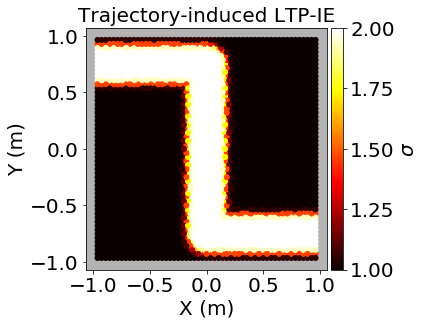

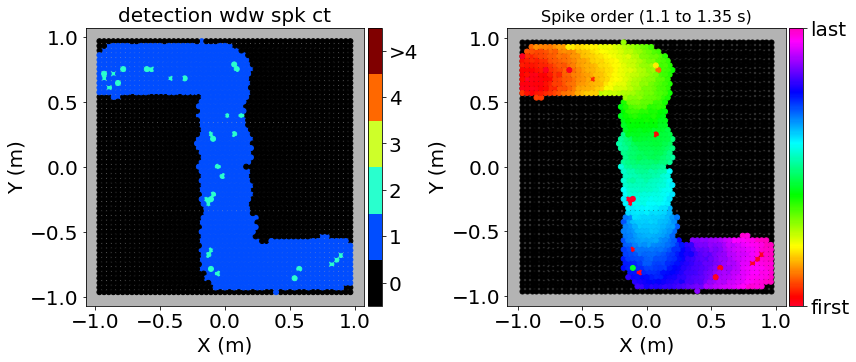

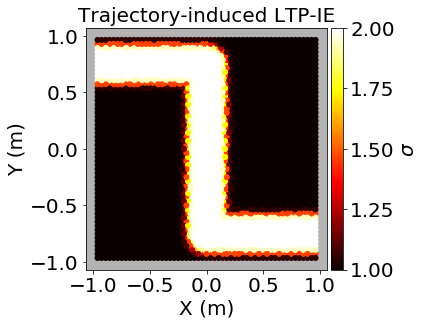

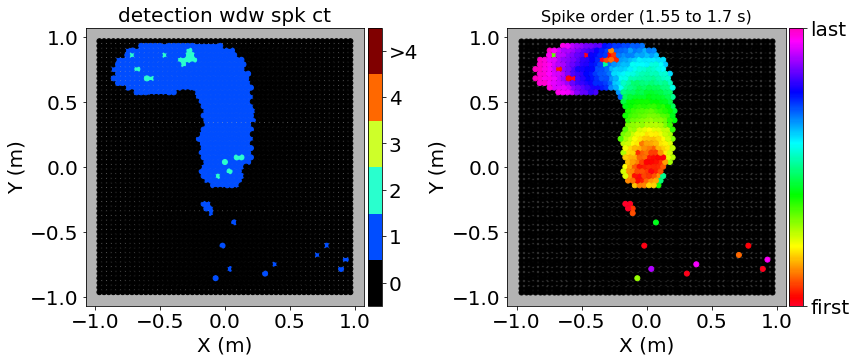

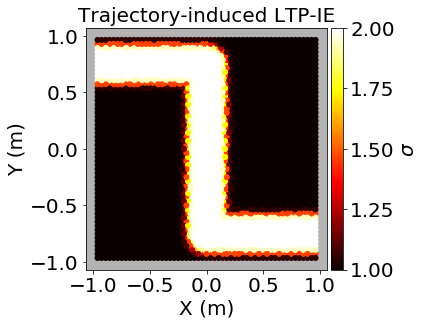

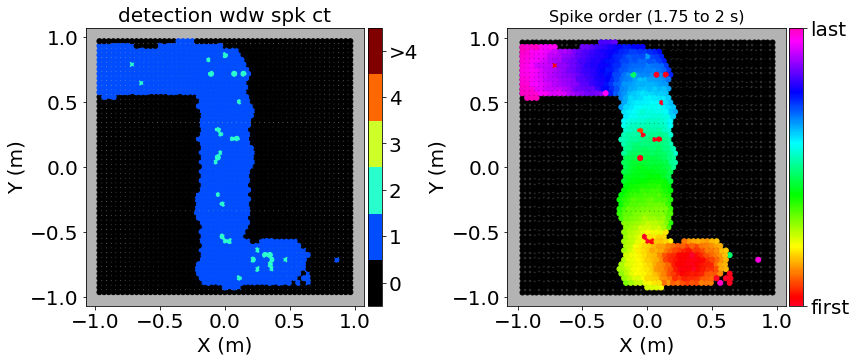

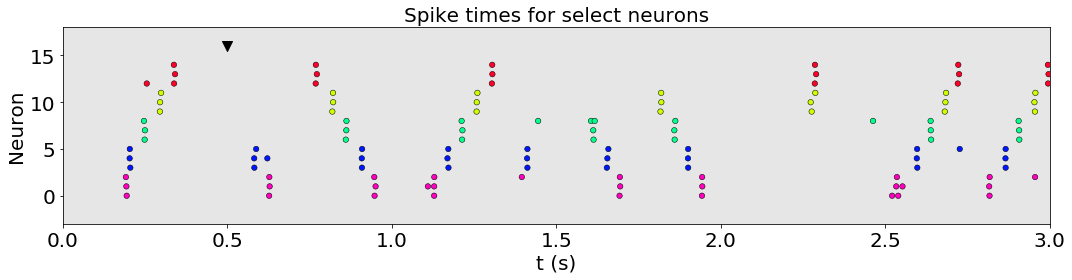

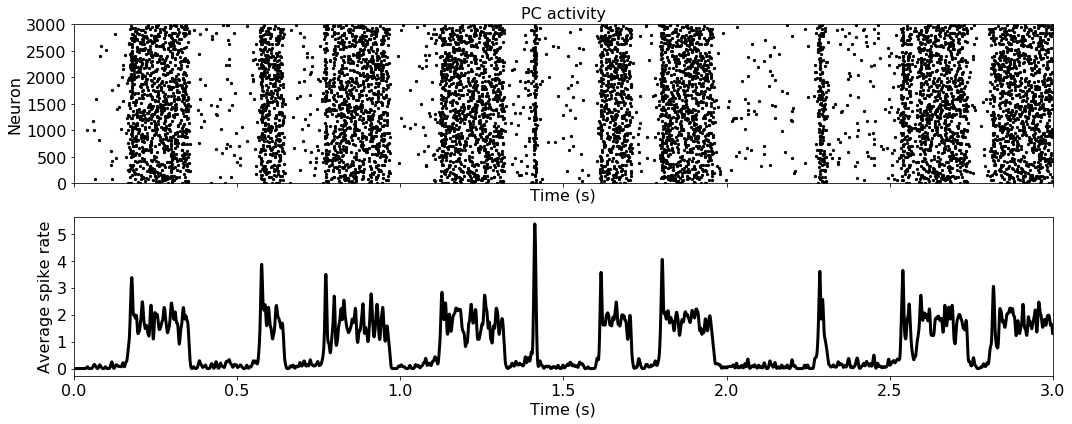

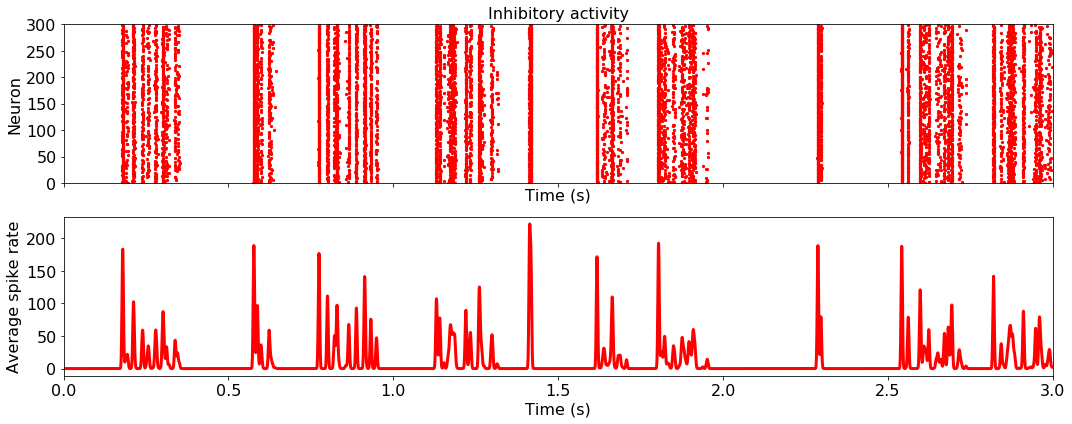

In [2]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 12
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
## full replay
ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(.73, 1.))[1][1][1]
ax.set_title('Spike order (.73 to 1. s)', fontsize=16)

## partial replay
ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(1.1, 1.35))[1][1][1]
ax.set_title('Spike order (1.1 to 1.35 s)', fontsize=16)

ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(1.55, 1.7))[1][1][1]
ax.set_title('Spike order (1.55 to 1.7 s)', fontsize=16)

ax = plot.heat_maps(rslt, cmap='gist_rainbow', epoch=(1.75, 2.))[1][1][1]
ax.set_title('Spike order (1.75 to 2 s)', fontsize=16)

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons',
)

plot.plot_pc(rslt, smoothness=4)
plot.plot_inh(rslt, smoothness=4);

In [3]:
def remove_short_gaps(starts, ends, min_gap):
    """Remove short gaps from list of starts and end times denoting events."""
    gaps = starts[1:] - ends[:-1]  # get gap times (n-1 gaps for n starts and ends)
    mask = gaps >= min_gap  # find all sufficiently long gaps (len n-1)
    
    # convert to proper length mask to select corrected starts and ends
    return starts[cc([[True], mask])], ends[cc([mask, [True]])]


def remove_short_evts(starts, ends, min_evt):
    """Remove short events from list of starts and end times denoting events."""
    mask = (ends - starts) >= min_evt
    return starts[mask], ends[mask]


def get_evts(rslt, a_params):
    """Return start and end times of candidate replay events."""
    # get PC firing rates
    ## PC spks
    spks_pc = rslt.spks[:, :rslt.p['N_PC']]
    ## smoothed instantaneous firing rate avg'd over PCs
    fr_pc = smooth(spks_pc.sum(axis=1) / (rslt.dt * rslt.p['N_PC']), a_params['SMOOTH_FR'])
    
    # get start and end time idxs when PC FR is above threshold
    starts, ends = get_segments(fr_pc >= a_params['evt_dtcn_th'])
    # convert to time
    starts *= rslt.dt
    ends *= rslt.dt
    
    # remove too-short gaps btwn events
    starts, ends = remove_short_gaps(starts, ends, a_params['MIN_GAP_DUR'])
    
    # remove too-short events
    starts, ends = remove_short_evts(starts, ends, a_params['MIN_EVT_DUR'])
    
    return starts, ends
    

def check_blowup(rslt, start, end, a_params):
    """Check whether event exhibits "blowup" behavior."""
    return


def check_one_way(rslt, start, end, a_params):
    """Check whether event exhibits one-way propagation."""
    return

    
def get_metrics(rslt, a_params):
    """
    Compute metrics from network simulation run:
        (1) evt_ct: spontaneous event frequency
        (2) evt_dur: avg spontaneous event duration
        (3) class: blowup, replay (unidirectional), or other
        (4) speed: virtual replay speed
    """
    metrics = {}
    
    # get candidate replay event start and end times
    starts, ends = get_evts(rslt, a_params)
    
    # calc event freq
    metrics['evt_ct'] = len(starts)
    
    # calc mean event dur
    metrics['evt_dur'] = np.mean(ends - starts)
    
    # test for blowup and unidirectionality
    if check_blowup(rslt, starts, ends, a_params):
        metrics['blowup_frac'] = 'blowup'
    elif check_one_way(rslt, starts, ends, a_params):
        metrics['one_way_frac'] = 'one_way'
    else:
        metrics['other_frac'] = 'other'
    
    # calc replay speed
    if metrics['class'] == 'one_way':
        metrics['speed'] = calc_replay_speed(rslt, starts, ends, a_params)
    else:
        metrics['speed'] = None
    
    return metrics

## Test analysis functions

In [4]:
def test_evt_processing():
    a_params = {'MIN_GAP_DUR': 0.25, 'MIN_EVT_DUR': 0.25}
    
    starts, ends = np.array([
        [0.1, 0.9, 1.2, 2.0, 3.6, 4.6, 6.9, 7.2, 9.5],
        [0.6, 1.1, 1.9, 2.8, 3.8, 5.7, 7.1, 8.4, 9.6],
    ])
    
    starts_desired = np.array([0.1, 0.9, 4.6, 6.9])
    ends_desired = np.array([0.6, 2.8, 5.7, 8.4])
    
    # remove short gaps and short events
    starts, ends = remove_short_gaps(starts, ends, a_params['MIN_GAP_DUR'])
    starts, ends = remove_short_evts(starts, ends, a_params['MIN_EVT_DUR'])
    
    print('Desired starts:', starts_desired)
    print('Actual  starts:', starts)
    print('Desired ends:', ends_desired)
    print('Actual  ends:', ends)
    
test_evt_processing()

Desired starts: [0.1 0.9 4.6 6.9]
Actual  starts: [0.1 0.9 4.6 6.9]
Desired ends: [0.6 2.8 5.7 8.4]
Actual  ends: [0.6 2.8 5.7 8.4]
